# Introduction to Data Science – Homework 6
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, February 23, 11:59pm.

In Part 1 of this homework you will scrape github repositories and organize the information in a Pandas dataframe. In Part 2, you will use linear regression to gain meaningful insights. 

## Your Data
*First Name:* Rebecca
<br>
*Last Name:* Rodriguez
<br>


In [1]:
# imports and setup 
from bs4 import BeautifulSoup
# you can use either of these libraries to get html from a website
import requests
import urllib.request
import re

import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

print("done")

done


### 1. Scrape Github Repository List and Repository Information using BeautifulSoup
In this part you will explore over 2 million Github repositories. You are going to scrape [this repository list](https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories).

### 1.1. Check whether you are permitted to scrape the data
Before you start to scrape any website you should go through the terms and services or similar pages of the website. Almost all websites post conditions to use their data. Check the terms of [https://github.com/](https://github.com/) to see whether the site permits you to scrape their data or not. Are you sure you are allowed to scrape?

**Your Interpretation:**
TODO

### Task 1.2 Download the website

Download the **first ten** pages of the list of highly starred repositories here: 

https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories

To avoid sending too many requests to the server, make sure that your querying code is in a sperate cell from anything else, so that you don't have to re-run it needlessly. 

**Warning:** while we haven't experienced any problems, exepct that github will temporarily block access if you scrape their website relentlessly. Make sure to be responsible. Also, don't do this last minute – if you're blocked for e.g., 24 hours that could impact your timeline.

Now read the html text in python and create a soup object.

In [2]:
#function that converts a url into a BeautifulSoup object

def url_to_soup(url):
    with urllib.request.urlopen(url) as response:
        html = response.read()
        html = html.decode('utf-8')

    # save the file
    with open('git_repos.html', 'w', encoding = 'utf-8') as new_file:
        new_file.write(html)

    # here it's already a local operation
    soup = BeautifulSoup(html, 'html.parser')
    return soup 

print("done")

done


In [3]:
#Task 1.2a: download first ten pages of most-starred repositories

from time import sleep

#list to contain urls of 10 pages
pages = []

#first and last portion of url-- we'll insert the page number in the loop later
begin_link = 'https://github.com/search?o=desc&p='
end_link = '&q=stars%3A%3E1&s=stars&type=Repositories'

#add each url to the list
for i in range(1, 11):
    pages.append(begin_link + str(i) + end_link)
    
#list to contain soup objects of the 10 pages
soup_pages = []

#create soup objects of each url page and add to list
for page in pages[0:6]:
    soup_pages.append(url_to_soup(page))

#take a break so we don't get blocked
sleep(60)

for page in pages[6:]:
    soup_pages.append(url_to_soup(page))
    
print("done")

done


In [4]:
print(len(soup_pages))

10


### 1.3. Extract Data

Extract the following data for each repository, and create a Pandas Dataframe with a row for each repository and a column for each of these datums. 

1. Name of the repository
+ URL of the repository 
+ Number of Contributors 
+ Programming Language Used 
+ Number of stars 
+ Number of issues
+ Number of forks
+ Length of readme file.

Note that you will frist have to extract links from the soup that you just scraped earlier, and then download the repository pages to retreive most of the data. 

Refer to lecture 12 for details on how to do this. Make sure to use the web inspector to identify the relevant structures. 

Save the dataframe you created to a new file `project_info.csv` and include this in your submission.

In [5]:
#TESTING/DEBUGGING: gathering data by looping through list of page soup objects

#first portion of all repo urls
url_head = "https://github.com"

#lists to contain names, urls, issues, lang, stars
url_list = []
repo_names = []  #we'll need to remove the '/' from beginning of all names
language_list = []
stars_list = []

for i in range(len(soup_pages)):
    
    soup_thingy1 = soup_pages[i]

    #get names and urls of repos
    for repo in soup_thingy1.find_all(class_ = "v-align-middle"):
        #get the tail by retrieving link out the href attribute
        link_tail = repo.get("href")
        
        #if link_tail is None, it's not a repo-- don't add it!
        if link_tail is not None:
            #add tail to list of repo names (get rid of '/' in front)
            repo_names.append(link_tail[1:])
            #add url of repo to list of repo urls
            repo_url = url_head + link_tail
            url_list.append(repo_url)

    #get programming language
    for repo in soup_thingy1.find_all(class_ = "d-table-cell col-2 text-gray pt-2"):
        language = repo.get_text().strip() #strip white space
        language_list.append(language)

    #get number of stars
    for repo in soup_thingy1.find_all(class_ = "col-2 text-right pt-1 pr-3 pt-2"):
        #number of stars is embedded within <a> tag
        stars = repo.find("a").get_text().strip()
        stars_list.append(stars)


#printing/debugging
print("url list", len(url_list))
print("names list", len(repo_names))
print("lang list", len(language_list))
print("stars list", len(stars_list))
#print(url_list)
#print(repo_names)
#print(language_list)
#print(stars_list)


url list 100
names list 100
lang list 100
stars list 100


In [6]:
#convert repo urls to soup objs
#we can only access 9 pages every minute before getting blocked

repo_soup_list = []
count = 0

for i in range(len(url_list)):
    repo_soup_list.append(url_to_soup(url_list[i]))
    
    # we increment the count until we reach 9
    # then pause for 60 sec to prevent blocking
    count += 1
    if(count == 8):
        sleep(60)
        count = 0

print("done")
#this takes about 16 minutes


done


In [7]:
len(repo_soup_list)


100

In [8]:
## traverse ENTIRE list of repo soups objs and make lists of ALL 100 readme urls, issues, contributors, forks

#lists to hold data
issues_list = []
contrib_list = []
fork_list = []
readme_list = []

#loop through list of repo soup objs
for i in range(len(repo_soup_list)):
    repo_soup = repo_soup_list[i]
    
    ##get number of issues
    for tag in repo_soup.find(class_="Counter"):
        issues_list.append(tag)

    ##get number of contributers
    contrib_numbers = []
    #there are 4 data points in class "num text-emphasized"-- add them all to list
    for tag in repo_soup.find_all(class_="num text-emphasized"):
        contrib_numbers.append(tag.get_text().strip())
    #number of contribs is always 4th element-- let's grab it from our list
    #if it's NoneType, it's not a contributor!
    if contrib_numbers[3] is not None:
        contrib_list.append(contrib_numbers[3])

    ##get number of forks
    fork_numbers = []
    #there are 3 data points in class "social-count"-- add them all to list
    for tag in repo_soup.find_all(class_="social-count"):
        fork_numbers.append(tag.get_text().strip())
    #number of forks is always 3rd element-- let's grab it from our list
    #if it's NoneType, it's not a fork!
    if fork_numbers[2] is not None:
        fork_list.append(fork_numbers[2])    
      
    ##get url for readme file
    #find tag with href containing readme
    if (repo_soup.find_all("a", href=re.compile("README.md")) == []):
        if (repo_soup.find_all("a", href=re.compile("blob/master/R")) == []):
            readme = repo_soup.find_all("a", href=re.compile("blob/master/read"))
        else:
            readme = repo_soup.find_all("a", href=re.compile("blob/master/Read"))
    else:
        readme = repo_soup.find_all("a", href=re.compile("README"))
    #traverse the tag and grab the url 
    for tag in readme:
        readme_tail = tag.get("href")
    #combine url with github url head for full link to readme file
    #first check if url already contains github header
    if "https://github" in readme_tail:
        readme_url = readme_tail.split("#")[0]
    else:
        readme_url = (url_head + readme_tail).split("#")[0] #this gets rid of anything after and including hashtag
    #print(readme_url)
    #add to list of all readme urls
    readme_list.append(readme_url)


    
##printing/debugging
# print(readme_list)
# print(issues_list)
# print(contrib_list)
# print(fork_list)
print(len(issues_list))
print(len(contrib_list))
print(len(fork_list))
print(len(readme_list))

#reference for finding word in href
#https://stackoverflow.com/questions/38252434/beautifulsoup-to-find-a-link-that-contains-a-specific-word

#how to keep first item up to but not including ";"
#line.split(";")[0]

100
100
100
100


In [9]:
##change repeated urls manually-- it's just faster this way
# 'https://github.com/mui-org/material-ui/blob/v1-beta/README.md' [53,54]
readme_list[53] = 'https://github.com/pallets/flask/blob/master/README.rst'
readme_list[54] = 'https://github.com/jekyll/jekyll/blob/master/README.markdown'

# 'https://github.com/ripienaar/free-for-dev/blob/master/README.md' [63]
readme_list[63] = 'https://github.com/django/django/blob/master/README.rst'

# 'https://github.com/AFNetworking/AFNetworking/blob/master/README.md' [70]
readme_list[70] = 'https://github.com/requests/requests/blob/master/README.rst'

# 'https://github.com/ssshooter/MyDiary-Vue/blob/master/README.En.md'
readme_list[79] = 'https://github.com/elastic/elasticsearch/blob/master/README.textile'

##initiate list for readme soup objs
readme_soup = []

In [10]:
##traverse ENTIRE list of readme urls and make list of ALL 100 readme soup objs

#run 9 every minute so we don't get blocked

#make soup objects for each readme url
for i in range(len(readme_list)):
    #every 9th item, pause so we don't get blocked
    if (i % 9 == 0):
        sleep(60)
    
    readme_soup.append(url_to_soup(readme_list[i]))


print("done")
print(len(readme_soup))

done
100


In [11]:
# #debugging

# #initiate variables to be used below
# readme_soup_tester = []
# count_tester = 0


In [12]:
# #debugging-- THIS GIVES CORRECT SOUP LIST! but manually ran for loop each time

# # for i in range(9):
# #     readme_soup_tester.append(url_to_soup(readme_list[i]))
# #     count_tester += 1

# # begin = count_tester
# # end = count_tester + 9

# #wait 60 sec

# for i in range(begin,end):
#     readme_soup_tester.append(url_to_soup(readme_list[i]))
#     count_tester += 1
    
# begin = count_tester
# end = count_tester + 9
# if end > 100:
#     end = 100


# print("count", count_tester)
# print("list size", len(readme_soup_tester))


In [13]:
## traverse ENTIRE list of readme soup objs and make list of ALL 100 readme file sizes

readme_file_sizes = []

#make list of readme file sizes
for i in range(len(readme_soup)):
    for tag in readme_soup[i].find_all(class_ = "file-info"):
        info = tag.get_text().strip()
        #print(info.splitlines())
        #file size is the third element of file info
        readme_size = info.splitlines()[2].strip()
        #print(readme_size)
        readme_file_sizes.append(readme_size)
    

#printing/debugging
#print(readme_file_sizes)
print(len(readme_file_sizes))


100


In [14]:
# Convert lists into DataFrame

repos_df = (pd.DataFrame({'Repo Name': repo_names, 'URL': url_list, 'Contributors': contrib_list, 
                                   'ProgrammingLanguage': language_list, 'Stars': stars_list, 'Issues': issues_list,
                                   'Forks': fork_list, 'Readme File Size': readme_file_sizes}))

#reorder columns
repos_df = repos_df[['Repo Name', 'URL', 'Contributors', 'ProgrammingLanguage', 'Stars', 'Issues', 'Forks', 'Readme File Size']]

#visually inspect df
#repos_df.tail(10)


In [15]:
# Save dataframe to file project_info.csv

repos_df.to_csv('project_info.csv')

### 2. Use linear regression to analyze the Github repository data

In this part, you will analyze the data collected in Part 1 using regression tools. The goal is to identify properties that make a repository popular. 

First, load the project_info.csv file in again. **We need you to do this so that we can run your code below withouth having to run your scraping code.**

In [45]:
# this loads the data from the project_info.csv file 
project_info = pd.read_csv('project_info.csv', index_col=0)

#inspect data
project_info.head(20)

,Repo Name,URL,Contributors,ProgrammingLanguage,Stars,Issues,Forks,Readme File Size
0,freeCodeCamp/freeCodeCamp,https://github.com/freeCodeCamp/freeCodeCamp,773,JavaScript,292k,170,"13,799",4.13 KB
1,twbs/bootstrap,https://github.com/twbs/bootstrap,"1,005",CSS,124k,339,"59,662",9.05 KB
2,EbookFoundation/free-programming-books,https://github.com/EbookFoundation/free-progra...,992,NaN,105k,14,"26,766",4.08 KB
3,tensorflow/tensorflow,https://github.com/tensorflow/tensorflow,"1,468",C++,99.1k,"1,356","62,730",10.5 KB
4,facebook/react,https://github.com/facebook/react,"1,178",JavaScript,95.5k,372,"17,977",5.07 KB
5,vuejs/vue,https://github.com/vuejs/vue,190,JavaScript,93.8k,121,"13,820",15.1 KB
6,sindresorhus/awesome,https://github.com/sindresorhus/awesome,323,NaN,84.7k,41,"11,154",35.6 KB
7,getify/You-Dont-Know-JS,https://github.com/getify/You-Dont-Know-JS,159,NaN,81.6k,121,"15,023",663 Bytes
8,d3/d3,https://github.com/d3/d3,123,JavaScript,75.7k,1,"19,256",2.24 KB
9,airbnb/javascript,https://github.com/airbnb/javascript,391,JavaScript,70.6k,94,"13,492",46 KB


### 2.1. Reformat the data into useful datatypes

1. Print the data types for the columns of your dataframe
+ Reformat the colums Issues, Forks, Stars, and Contributers to be integer data
+ There is one repository flagged as having infinite contributers (the Linux kernel). We'll assume that it in fact has 15000 contributors (about twice as much as the next project). 

In [46]:
#Task 2.1

#reformat convert data type of stars column
project_info['Stars'] = project_info['Stars'].str.replace('k','')
project_info['Stars'] = project_info['Stars'].astype(float)
project_info['Stars'] = project_info['Stars']*1000
project_info['Stars'] = project_info['Stars'].astype(int)

#reformat and convert data type of forks column
project_info['Forks'] = project_info['Forks'].str.replace(',','')
project_info['Forks'] = project_info['Forks'].astype(int)

#reformat and convert data type of contributors column
con_idx = project_info.index[project_info['Contributors'] == '?']
project_info.at[15, 'Contributors'] = 15000 #replace infinity w/15000
project_info['Contributors'] = project_info['Contributors'].str.replace(',','')
project_info['Contributors'].fillna(0, inplace = True) #replace nan w/0
project_info['Contributors'] = project_info['Contributors'].astype(int)

#reformat and convert data type of issues column
project_info['Issues'] = project_info['Issues'].str.replace(',','')
project_info['Issues'] = project_info['Issues'].astype(int)

#reformat and convert data type of readme file size
#first split size (number) and size type (KB, Byte, etc) and make new columns for these
project_info['ReadmeSize'], project_info['Readme Size (type)'] = project_info['Readme File Size'].str.split(' ', 1).str
project_info['ReadmeSize'] = project_info['ReadmeSize'].astype(float)
project_info['Readme Size (type)'] = project_info['Readme Size (type)'].astype(str)

#omit the rows with readme sizes that are not KB (these are not typical)
project_info = project_info[project_info['Readme Size (type)'] == "KB"] 


    
#inspect data
project_info.head(20)
# project_info.info()


,Repo Name,URL,Contributors,ProgrammingLanguage,Stars,Issues,Forks,Readme File Size,ReadmeSize,Readme Size (type)
0,freeCodeCamp/freeCodeCamp,https://github.com/freeCodeCamp/freeCodeCamp,773,JavaScript,292000,170,13799,4.13 KB,4.13,KB
1,twbs/bootstrap,https://github.com/twbs/bootstrap,1005,CSS,124000,339,59662,9.05 KB,9.05,KB
2,EbookFoundation/free-programming-books,https://github.com/EbookFoundation/free-progra...,992,NaN,105000,14,26766,4.08 KB,4.08,KB
3,tensorflow/tensorflow,https://github.com/tensorflow/tensorflow,1468,C++,99100,1356,62730,10.5 KB,10.50,KB
4,facebook/react,https://github.com/facebook/react,1178,JavaScript,95500,372,17977,5.07 KB,5.07,KB
5,vuejs/vue,https://github.com/vuejs/vue,190,JavaScript,93800,121,13820,15.1 KB,15.10,KB
6,sindresorhus/awesome,https://github.com/sindresorhus/awesome,323,NaN,84700,41,11154,35.6 KB,35.60,KB
8,d3/d3,https://github.com/d3/d3,123,JavaScript,75700,1,19256,2.24 KB,2.24,KB
9,airbnb/javascript,https://github.com/airbnb/javascript,391,JavaScript,70600,94,13492,46 KB,46.00,KB
10,robbyrussell/oh-my-zsh,https://github.com/robbyrussell/oh-my-zsh,1126,Shell,70200,531,14601,9.1 KB,9.10,KB


### Task 2.2 Describe the data

+ Get an overview of the data using the describe function.
+ Compute the correlation matrix, visualize it with a heat map.
+ Visualize the correlations by making a scatterplot matrix.
+ Interprete what you see.

You can re-use code from your previous homework here.

In [47]:
#Task 2.2a: describe data

#descriptive stats of data
project_info.describe()


,Contributors,Stars,Issues,Forks,ReadmeSize
count,94.000000,94.000000,94.000000,94.000000,94.000000
mean,508.712766,45526.585106,599.595745,10221.031915,20.079149
std,577.531596,31802.223153,1000.847934,9526.555627,36.495090
min,0.000000,28000.000000,0.000000,714.000000,1.150000
25%,99.500000,31625.000000,35.500000,5023.000000,3.250000
50%,317.500000,35500.000000,195.500000,7957.500000,5.305000
75%,724.250000,48650.000000,588.000000,11723.000000,15.175000
max,3448.000000,292000.000000,4611.000000,62730.000000,180.000000


,Stars,Contributors,Issues,Forks,ReadmeSize
Stars,1.000000,0.165333,-0.047121,0.469030,-0.045733
Contributors,0.165333,1.000000,0.462234,0.333193,0.164828
Issues,-0.047121,0.462234,1.000000,0.033487,0.001615
Forks,0.469030,0.333193,0.033487,1.000000,-0.037180
ReadmeSize,-0.045733,0.164828,0.001615,-0.037180,1.000000


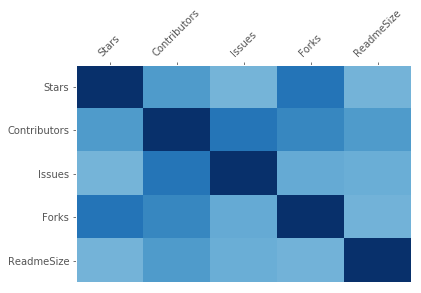

In [48]:
#Task 2.2b: visualize correlations with matrix and heat map

#correlation matrix (w/variables from Task 2.2a descriptive stats)
project_info_sub1 = project_info[['Stars', 'Contributors', 'Issues', 'Forks', 'ReadmeSize']]
project_info_sub1.corr()

#plot the heatmap
fig, ax = plt.subplots()
heatmap_sub1 = ax.pcolor(project_info_sub1.corr(), cmap=plt.cm.Blues, vmin=-1, vmax=1)

#invert the plot to have diagonal top left to bottom right
ax.invert_yaxis()
ax.xaxis.tick_top()

#set tick marks
ax.set_xticks(np.arange(len(list(project_info_sub1))) + .5, minor=False) # +.5 to center
ax.set_yticks(np.arange(len(list(project_info_sub1))) + .5, minor=False)
plt.xticks(rotation=45) #rotate x-labels

#label the plot
ax.set_xticklabels(project_info_sub1.columns, minor=False)
ax.set_yticklabels(project_info_sub1.columns, minor=False)

project_info_sub1.corr()

**Your Interpretation:** From our correlation matrix and heatmap of the quantitative variables (Stars, Contributors, Issues, Forks and Readme Size), we can identify which variables are most and least correlated with one another. Initially, we notice that, compared to a correlation of 1 (which we see along the diagonal), there are no other variables with particularly strong correlations to one another. Perhaps the strongest positive, non-diagonal correlations are between Forks and Stars, and between Contributors and all other variables (except for Readme Size). In fact, we see that the correlations between Readme Size and all other variables is practically non-existent. 

### 2.3. Linear regression

1. First use linear regression to try to predict the number of Stars based on Forks, Contributors, Issues, and Readme Length. Explain why this is not a very good model by discussing the R-squared , F-statistic p-value, and coefficient  p-values. 
+ Develop another model which is better. Explain why it is better and interpret your results. 

In [49]:
# Task 2.3: linear regression

#Task 2.3.1: regress stars with Forks, Contributors, Issues, and Readme Size
sm.ols(formula = "Stars ~ Contributors + Issues + Forks + ReadmeSize", data = project_info_sub1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     6.552
Date:                Fri, 11 May 2018   Prob (F-statistic):           0.000114
Time:                        15:35:14   Log-Likelihood:                -1095.3
No. Observations:                  94   AIC:                             2201.
Df Residuals:                      89   BIC:                             2213.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.084e+04   4998.938      6.168      0.000    2.09e+04    4.08e+04
Contributors     3.5667      6.342      0.562      0.575      -9.036      16.169
Issues          -2.9244      3.391     -0.862      0.391      -9.662       3.814
Forks            1.4991      0.335      4.468      0.000       0.832       2.166
ReadmeSize     -34.4769     83.145     -0.415      0.679    -199.684     130.730
==============================================================================
Omnibus:                      166.468   Durbin-Watson:                   1.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12422.306
Skew:                           6.759   Prob(JB):                         0.00
Kurtosis:                      57.671   Cond. No.                     2.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Your interpretation: Task 2.3.1**

Our model regressing Stars with Forks, Contributors, Issues, and Readme Size is insufficient to say the least. The R-squared value, which measures the ratio of variability explained by our model, is a measly 0.221. That is, Forks, Contributors, Issues, and Readme Size only explain 22% of the variability of Stars. The F-statistic is very small, 2.07e4, indicating our model is in fact significant. When we consider the coefficient P-values of the variables, we notice only one variable, Forks, has a P-value less than any typical significance level .01 or .05. This indicates that only Forks has a relationship with Stars. The other variables, unfortunately, do not have any relationship with Stars. 

In [51]:
#Task 2.3.2a: regress stars with Forks

sm.ols(formula = "Stars ~ Forks", data = project_info_sub1).fit().summary()

#Task 2.3.2b: regress stars with Forks and Programming Language
# sm.ols(formula = "Stars ~ Forks + ProgrammingLanguage", data = project_info_sub1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     25.95
Date:                Fri, 11 May 2018   Prob (F-statistic):           1.86e-06
Time:                        15:37:27   Log-Likelihood:                -1095.7
No. Observations:                  94   AIC:                             2195.
Df Residuals:                      92   BIC:                             2201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.952e+04   4284.193      6.891      0.000     2.1e+04     3.8e+04
Forks          1.5657      0.307      5.094      0.000       0.955       2.176
==============================================================================
Omnibus:                      168.214   Durbin-Watson:                   1.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13020.854
Skew:                           6.875   Prob(JB):                         0.00
Kurtosis:                      58.995   Cond. No.                     2.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

** Your interpretation:** Since Forks is the only quantitative variable with any relationship to Stars, we attempt to create a model regressing only Stars and Forks. This, however, yields an R-squared value less than that in our model from Task 2.3.1. Perhaps an alternative model that could yield more significant results would attempt to regress Stars with Forks and a categorical variable such as Programming Language. We might find that the type of Programming Language for the repository could be a major contributor to the number of stars the repository has. 